In [171]:
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
from helpers import vec

In [174]:
from Systems import AutoDiffSystemModel

# Kinematic Car Example With Non-Linear Drag and Turbulence
#  - state: {position, velocity}
#  - control: {acceleration}
#  - dynamics: f(x, u) = [
#       position + velocity*dt + (1/2)(acceleration + noise_accel)*dt^2,
#       velocity + (acceleration - sign(v) * drag)*dt
#   ] where
#       drag = drag_coeff1*velocity + (drag_coeff2 + noise_drag)*velocity^2
#  - measurement: h(x) = position + noise


dt = 0.1
drag_coeff1 = 0.0
drag_coeff2 = 0.4

def dynamics_func(x, u, w):
    pos, vel = x.flatten()
    acc = u.flatten()[0]
    noise_acc, noise_drag = w.flatten()
    drag = drag_coeff1*vel + (drag_coeff2 + noise_drag)*vel**2  # <-- non-linear dependence on v
    return jnp.array([
        [pos + vel*dt + 0.5*(acc + noise_acc)*dt**2],
        [vel + (acc - jnp.sign(vel)*drag)*dt]
    ])

def measurement_func(x, v):
    pos, vel = x.flatten()
    noise = v.flatten()[0]
    return jnp.array([
        [pos + noise]
    ])

# dynamics noise covariance
accel_noise_variance = 0.01
drag_noise_variance = 0.001
R = jnp.array([
    [accel_noise_variance, 0],
    [0, drag_noise_variance]
])

# measurement noise covariance
measurement_variance = 0.3
Q = jnp.array([
    [measurement_variance]
])

car_system_gt = AutoDiffSystemModel(2, 1, 1, dynamics_func, measurement_func, R, Q)

In [175]:
from Filters import ExtendedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter_EKF = ExtendedKalmanFilter(car_system_approx)

100%|██████████| 149/149 [00:00<00:00, 727.52it/s]


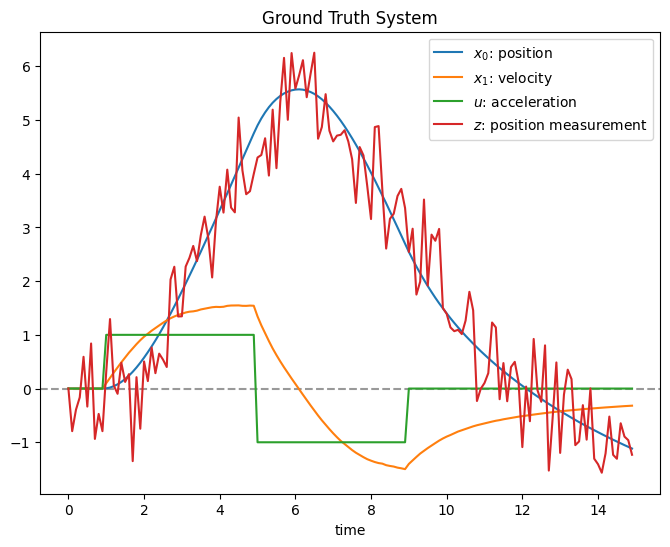

In [176]:
# Run the simulation

timesteps = np.arange(0.0, 15.0, step=dt)
T = len(timesteps)

states_gt = np.zeros((T, 2, 1))
controls = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = vec(0, 0)

measurements = np.zeros((T, 1, 1))

# acceleration schedule
controls[10:50] = vec(1.0)
controls[50:90] = vec(-1.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = car_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = car_system_gt.query_measurement_model(x)
    measurements[t] = z

# Plot results
plt.figure(figsize=(8, 6))
plt.title("Ground Truth System")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.legend()

In [177]:
# Test all filters with the same initial belief
initial_state_estimate = (
    vec(np.random.uniform(-1, 1), np.random.uniform(-1, 1)),     # initial mean
    np.array([      # initial covariance
        [0.1, 0.0],
        [0.0, 0.1]
    ])
)
initial_state_estimate

(array([[0.98958922],
        [0.61925446]]),
 array([[0.1, 0. ],
        [0. , 0.1]]))

100%|██████████| 149/149 [00:10<00:00, 14.55it/s]


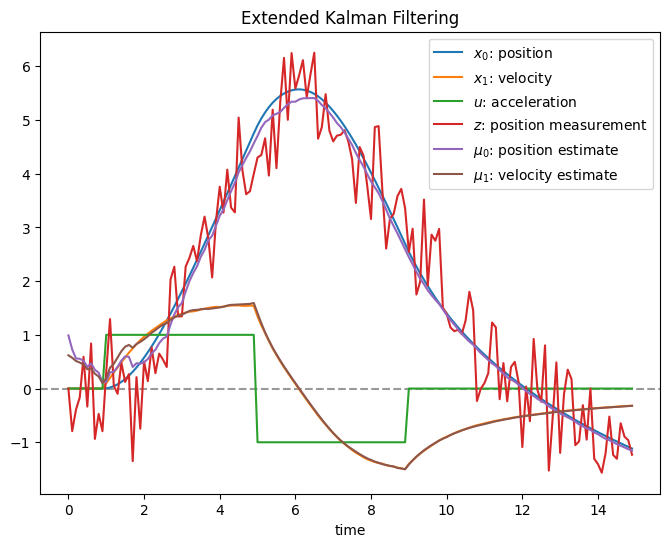

In [178]:
# Run the filter

# initial state belief
car_filter_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T, 2, 1))
covariances_EKF = np.zeros((T, 2, 2))

means_EKF[0] = car_filter_EKF.mean
covariances_EKF[0] = car_filter_EKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter_EKF.predict_step(u)
    car_filter_EKF.update_step(z)

    means_EKF[t] = car_filter_EKF.mean
    covariances_EKF[t] = car_filter_EKF.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Extended Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_EKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_EKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

In [179]:
from Filters import UnscentedKalmanFilter
from sigma_points import StandardSigmaPointSelector

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter_UKF = UnscentedKalmanFilter(
    car_system_approx,
    sigma_point_selector=StandardSigmaPointSelector(alpha=0.2)
)

100%|██████████| 149/149 [00:01<00:00, 95.61it/s]


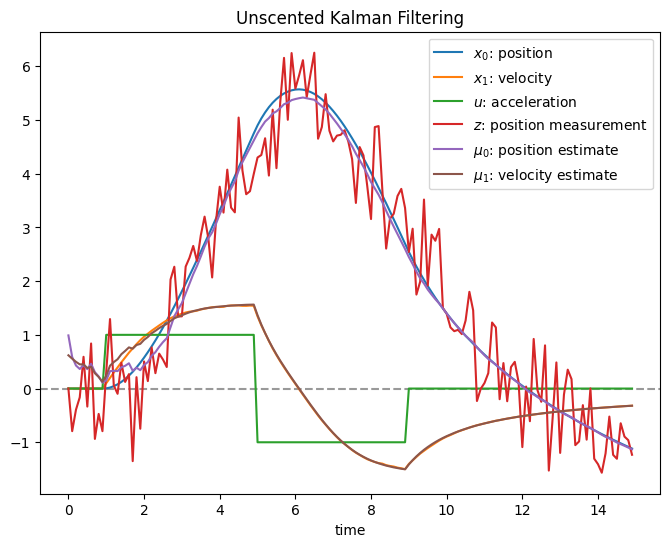

In [180]:
# Run the filter

# initial state belief
car_filter_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T, 2, 1))
covariances_UKF = np.zeros((T, 2, 2))

means_UKF[0] = car_filter_UKF.mean
covariances_UKF[0] = car_filter_UKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter_UKF.predict_step(u)
    car_filter_UKF.update_step(z)

    means_UKF[t] = car_filter_UKF.mean
    covariances_UKF[t] = car_filter_UKF.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Unscented Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_UKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_UKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

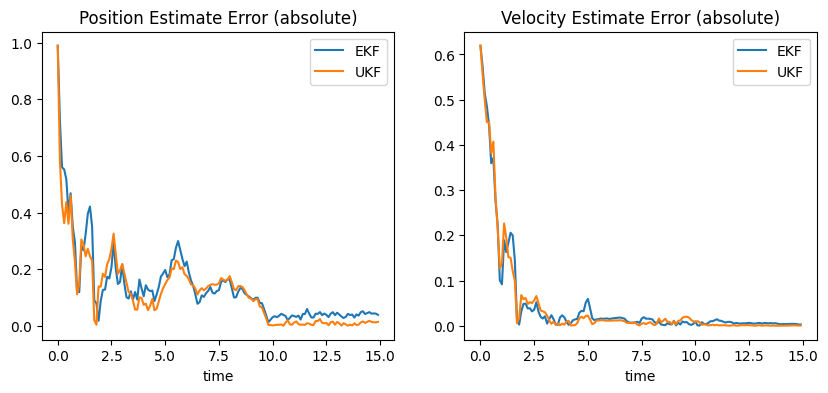

In [181]:
# Error analysis

errors_EKF = means_EKF - states_gt
errors_UKF = means_UKF - states_gt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Position Estimate Error (absolute)")
ax1.set_xlabel("time")
ax1.plot(timesteps, np.abs(errors_EKF[:, 0]), label="EKF")
ax1.plot(timesteps, np.abs(errors_UKF[:, 0]), label="UKF")
ax1.legend()

ax2.set_title("Velocity Estimate Error (absolute)")
ax2.set_xlabel("time")
ax2.plot(timesteps, np.abs(errors_EKF[:, 1]), label="EKF")
ax2.plot(timesteps, np.abs(errors_UKF[:, 1]), label="UKF")
ax2.legend()